#### Which type of error takes more time for the agent to solve? \
#### For each type of error, report the solve rate and avg time/steps spent to solve each error

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from collections import defaultdict

# List of valid error types we want to keep
valid_errors = {
    'enverror', 'keyerror', 'runtimeerror', 
    'assertionerror', 'valueerror', 'syntaxerror', 'importerror',
    'attributeerror', 'outofmemoryerror', 'typeerror'
}

# Load the error_completion_with_next_steps data
with open('error_completion_with_next_steps.json', 'r') as f:
    data = json.load(f)

# Initialize lists to store error data
error_types = []
statuses = []
steps_taken = []
tasks = []
models = []

# Process the data
for task_name, task_data in data.items():
    for model_name, model_data in task_data.items():
        for session_id, session_data in model_data.items():
            if 'error_observations' in session_data:
                for error_entry in session_data['error_observations']:
                    # Extract error type from observation
                    error_observation = error_entry.get('observation', '')
                    
                    # Find the error type in the observation
                    error_type = None
                    for err in valid_errors:
                        if err in error_observation.lower():
                            error_type = err
                            break
                    
                    # Skip if not a valid error type
                    if error_type is None:
                        print("Some Error in Code!!!")
                        continue
                    
                    # Get status (1 = fixed, 2 or 3 = not fixed)
                    status = error_entry.get('Status', 0)
                    
                    # Calculate steps taken (if next_steps exists)
                    steps = 0
                    if status == 1 and 'FixedAtStep' in error_entry:
                        # For fixed errors, calculate steps from error occurrence to fix
                        error_step = error_entry.get('step', 0)
                        fixed_step = error_entry.get('FixedAtStep', 0)
                        steps = fixed_step - error_step
                    
                    # Store the data
                    error_types.append(error_type)
                    statuses.append(status)
                    steps_taken.append(steps)
                    tasks.append(task_name)
                    models.append(model_name)

# Create a DataFrame
df = pd.DataFrame({
    'error_type': error_types,
    'status': statuses,
    'steps_taken': steps_taken,
    'task': tasks,
    'model': models
})

# Clean up error types (remove leading \n if present)
df['error_type'] = df['error_type'].str.replace('\n', '')

# Calculate solve rate for each error type
solve_rates = df.groupby('error_type').apply(
    lambda x: (x['status'] == 1).sum() / len(x)
).reset_index(name='solve_rate')

# Calculate average steps taken for each error type
avg_steps = df.groupby('error_type')['steps_taken'].mean().reset_index(name='avg_steps')

# Calculate count of each error type
error_counts = df.groupby('error_type').size().reset_index(name='count')

# Merge the results
results = pd.merge(solve_rates, avg_steps, on='error_type')
results = pd.merge(results, error_counts, on='error_type')

# Sort by solve rate
results = results.sort_values('solve_rate', ascending=False)

In [2]:
colors = {
    'List Files': '#4169E1',          # Royal Blue
    'Copy File': '#98FB98',           # Pale Green
    'Undo Edit Script': '#DEB887',    # Burlywood
    'Execute Script': '#20B2AA',      # Light Sea Green
    'Final Answer': '#9370DB',        # Medium Purple
    'Understand File': '#CD853F',     # Peru
    'Inspect Script Lines': '#FA8072', # Salmon
    'Edit Script (AI)': '#6495ED'     # Cornflower Blue
}

# Extract just the color values to use for our error types
color_values = list(colors.values())

# Create a mapping of error types to colors
error_colors = {}
for i, error_type in enumerate(results['error_type']):
    error_colors[error_type] = color_values[i % len(color_values)]

Error Type Analysis:


,error_type,solve_rate,avg_steps,count
5,outofmemoryerror,1.000000,11.250000,4
1,attributeerror,0.470588,9.176471,17
3,importerror,0.382979,3.319149,47
4,keyerror,0.272727,2.090909,11
8,typeerror,0.052632,0.631579,19
2,enverror,0.033043,0.353043,575
7,syntaxerror,0.030303,0.333333,33
0,assertionerror,0.000000,0.000000,2
6,runtimeerror,0.000000,0.000000,8
9,valueerror,0.000000,0.000000,2


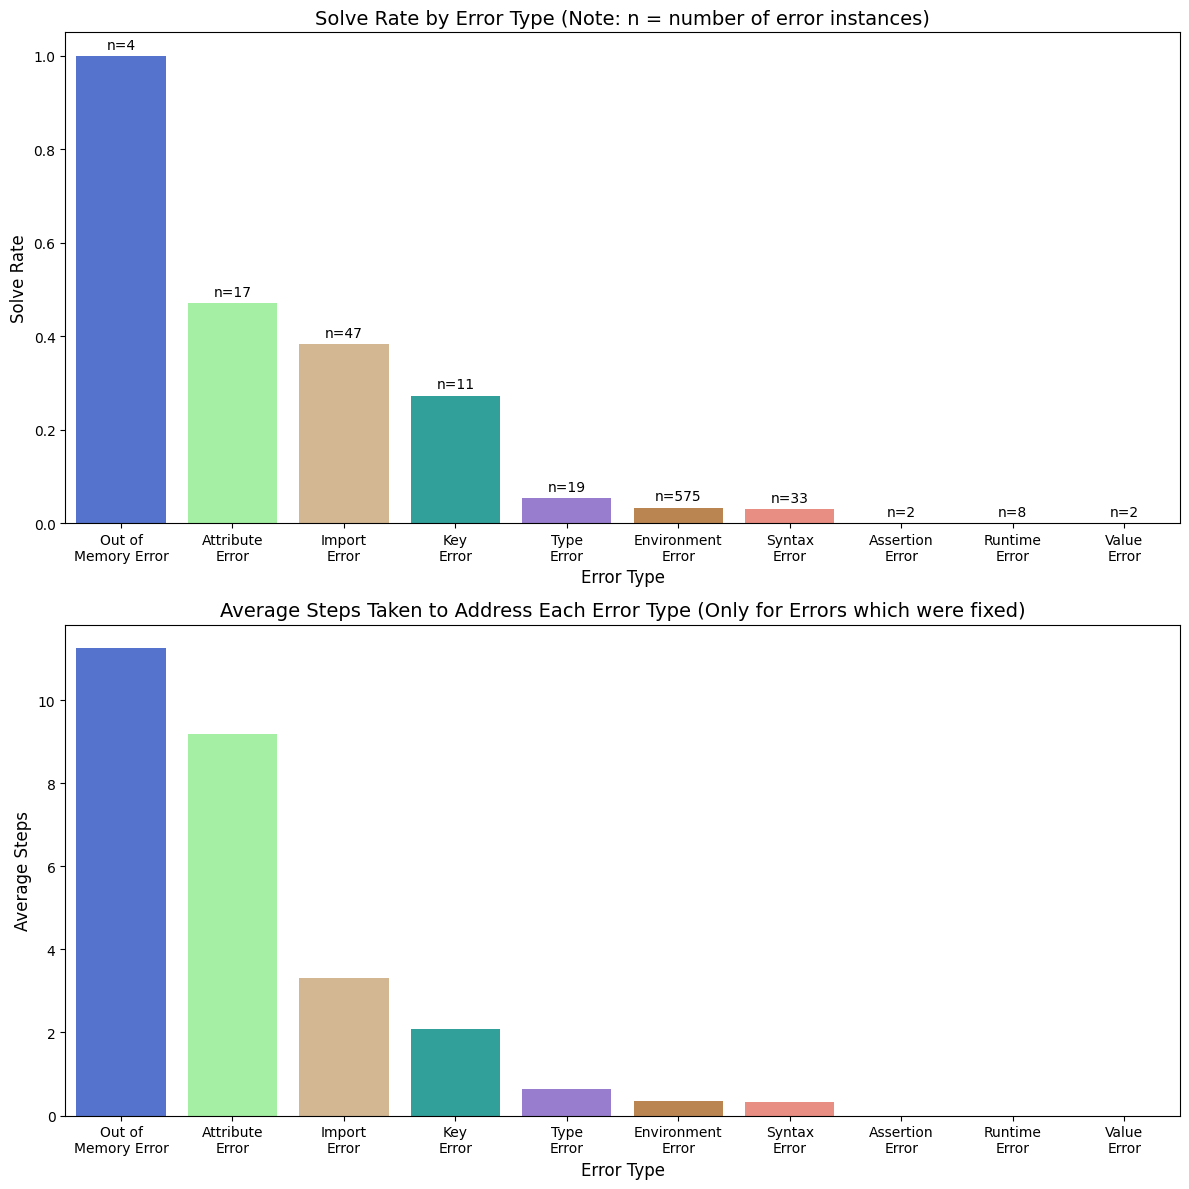

In [3]:
import textwrap
import os

# Create a mapping for better error type labels
error_labels = {
    'importerror': 'Import\nError',
    'typeerror': 'Type\nError',
    'outofmemoryerror': 'Out of\nMemory Error',
    'runtimeerror': 'Runtime\nError',
    'keyerror': 'Key\nError',
    'syntaxerror': 'Syntax\nError',
    'enverror': 'Environment\nError',
    'attributeerror': 'Attribute\nError',
    'assertionerror': 'Assertion\nError',
    'valueerror': 'Value\nError'
}

# Display the results
print("Error Type Analysis:")
display(results)

# Create a single figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot 1: Solve rates by error type
bars1 = sns.barplot(x='error_type', y='solve_rate', data=results, palette=error_colors, ax=ax1)
ax1.set_title('Solve Rate by Error Type (Note: n = number of error instances)', fontsize=14)
ax1.set_xlabel('Error Type', fontsize=12)
ax1.set_ylabel('Solve Rate', fontsize=12)

# Replace x-tick labels with better formatted ones
formatted_labels = [error_labels.get(err, err) for err in results['error_type']]
ax1.set_xticks(range(len(results['error_type'])))
ax1.set_xticklabels(formatted_labels)

# Add count annotations to the first plot - position them better
for i, p in enumerate(ax1.patches):
    count = results.iloc[i]['count']
    # Position the annotation at the top of each bar
    height = p.get_height()
    ax1.annotate(f'n={count}', 
                 (p.get_x() + p.get_width() / 2., height), 
                 ha='center', va='bottom',
                 fontsize=10,
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords='offset points')

# Plot 2: Average steps taken by error type
bars2 = sns.barplot(x='error_type', y='avg_steps', data=results, palette=error_colors, ax=ax2)
ax2.set_title('Average Steps Taken to Address Each Error Type (Only for Errors which were fixed)', fontsize=14)
ax2.set_xlabel('Error Type', fontsize=12)
ax2.set_ylabel('Average Steps', fontsize=12)

# Replace x-tick labels with better formatted ones
ax2.set_xticks(range(len(results['error_type'])))
ax2.set_xticklabels(formatted_labels)

plt.tight_layout()

# Save the figure
os.makedirs('Error_solve_rate', exist_ok=True)
plt.savefig('Error_solve_rate/error_solve_rate.pdf', dpi=300, bbox_inches='tight')

# Display the figure
plt.show()